In [1]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-1-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NOTE: Mediacloud news for state-specific collection includes news ABOUT the particular state, and as such, might sometimes contain news from national outlets where the article itself might be focused on the state itself. Most (if not all) of the collection is going to be sourced from local state-specific outlets, but not always. Currently, we are keeping all URLs within the obtained collection for the state, except those from nytimes and foxnews since those are our chosen national outlets. Trusting mediacloud's collections to be truly state-focused even when urls come from national outlets. 

In [2]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

In [3]:
ohio_news = pd.read_csv('data/mediacloud_ohio.csv')
print(ohio_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1563 entries, 0 to 1562
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   archived_url  1563 non-null   object
 1   article_url   1563 non-null   object
 2   id            1563 non-null   int64 
 3   language      1563 non-null   object
 4   media_name    1563 non-null   object
 5   media_url     1563 non-null   object
 6   publish_date  1563 non-null   object
 7   title         1563 non-null   object
 8   url           1563 non-null   object
dtypes: int64(1), object(8)
memory usage: 110.0+ KB
None


In [4]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(ohio_news['publish_date'])
month_to_vol = {}
for i in range(1, 13):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 1563/1563 [00:00<00:00, 838968.15it/s]


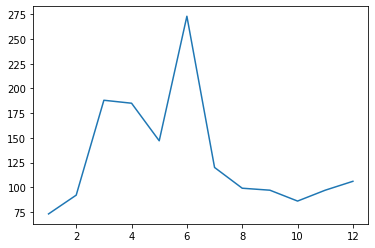

In [5]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [6]:
ohio_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url']].tail(20)

,language,media_name,media_url,publish_date,title,url
1543,en,woub.org,http://woub.org,2023-01-11 00:00:00,State lawmaker reintroduces a bill to limit the power of the Ohio State Board of Education,https://woub.org/2023/01/11/state-lawmaker-reintroduces-a-bill-to-limit-the-power-of-the-ohio-state-board-of-education/
1544,en,woub.org,http://woub.org,2023-01-31 00:00:00,Recent infighting raises the question: How conservative is the GOP?,https://woub.org/2023/01/31/recent-infighting-raises-the-question-how-conservative-is-the-gop/
1545,en,woub.org,http://woub.org,2023-02-06 00:00:00,"Beyoncé sets a new Grammy record, while Harry Styles wins album of the year",https://woub.org/2023/02/06/beyonce-sets-a-new-grammy-record-while-harry-styles-wins-album-of-the-year/
1546,en,woub.org,http://woub.org,2023-03-01 00:00:00,An Ohio Senate panel OKs a bill to overhaul Ohio’s education oversight,https://woub.org/2023/03/01/an-ohio-senate-panel-oks-a-bill-to-overhaul-ohios-education-oversight/
1547,en,woub.org,http://woub.org,2023-04-06 00:00:00,The Supreme Court won’t enforce a West Virginia law banning trans athletes from girls’ teams,https://woub.org/2023/04/06/supreme-court-west-virginia-ban-trans-athletes/
1548,en,woub.org,http://woub.org,2023-04-20 00:00:00,Protests break out as Ohio lawmakers hear two controversial bills affecting transgender youth,https://woub.org/2023/04/20/protests-ohio-lawmakers-bills-transgender-youth/
1549,en,woub.org,http://woub.org,2023-04-27 00:00:00,"Ohio House approves $88 billion state budget, sending it to the Senate",https://woub.org/2023/04/27/ohio-house-approves-88-billion-state-budget-sending-it-to-the-senate/
1550,en,woub.org,http://woub.org,2023-05-07 00:00:00,A key pro-choice group in Ohio gets a new leader as the battle over a reproductive rights amendment heats up,https://woub.org/2023/05/07/key-pro-choice-group-ohio-new-leader/
1551,en,woub.org,http://woub.org,2023-05-30 00:00:00,The state-level battles brewing in America over LGBTQ+ rights,https://woub.org/2023/05/30/state-level-battles-brewing-lgbtq-rights/
1552,en,woub.org,http://woub.org,2023-06-14 00:00:00,"Moms willing to risk losing friends, family, and faith communities to keep their kids safe, “Mama Bears” on INDEPENDENT LENS – June 20 at 10 pm",https://woub.org/2023/06/14/moms-willing-to-risk-losing-friends-family-and-faith-communities-to-keep-their-kids-safe-mama-bears-on-independent-lens-june-20-at-10-pm/


In [7]:
relevant_news = ohio_news[~ohio_news['media_name'].isin(['foxnews.com',
                                                         'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['media_name', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 1562
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   media_name    1541 non-null   object
 1   publish_date  1541 non-null   object
 2   title         1541 non-null   object
 3   url           1541 non-null   object
dtypes: object(4)
memory usage: 60.2+ KB
None


In [8]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 1562
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    1541 non-null   object        
 1   publish_date  1541 non-null   datetime64[ns]
 2   title         1541 non-null   object        
 3   url           1541 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 60.2+ KB
None


In [9]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        if subtitle == '' or subtitle == ' ':
            subtitle = None
        text = article.text
        if text == '' or text == ' ':
            text = None
    except:
        subtitle = None
        text = None
    return subtitle, text

In [10]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

100%|██████████| 1541/1541 [27:12<00:00,  1.06s/it]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 1562
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    1541 non-null   object        
 1   publish_date  1541 non-null   datetime64[ns]
 2   title         1541 non-null   object        
 3   url           1541 non-null   object        
 4   subtitle      884 non-null    object        
 5   text          1216 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 84.3+ KB
None


In [11]:
relevant_news.to_csv('data/ohio_article_texts_and_info.csv',
                     index=False)